In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865


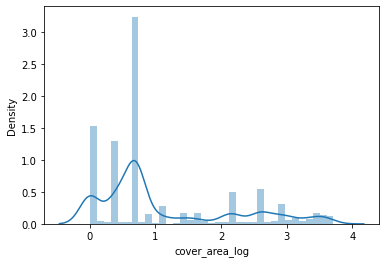

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [12]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [13]:
display(train[features])

,MIN_Blue_2018,MIN_DVIMSS_2020,MAX_SIPI2_2000,MIN_SIPI2_2013,MAX_ARI,MIN_mCRIG_2012,MAX_Gossan_2000,MAX_TIRS2_2005,MIN_IF_2008,MED_Chlred_edge_2013,...,MIN_IF_2000,MIN_Cirededge_2003,Fe3,MED_TCI,MAX_EVI_2003,MED_Fe3_2001,MIN_GARI_2002,MED_DSWI_2009,MIN_MVI_2006,MED_ARVI
0,49.615955,-1.725707,6.144052,3.638030,-12.509911,-0.082768,0.102534,8.960272,2.202680,2.170877,...,2.242761,-0.630688,0.502376,15.253905,0.089687,0.482824,NaN,2.942468,6.308290,0.551941
1,74.311127,-9.102529,NaN,2.220301,4.429682,NaN,NaN,8.743550,3.681952,2.458822,...,NaN,NaN,0.699943,109.885521,NaN,0.591882,NaN,NaN,19.946871,-0.097435
2,78.093918,-7.808941,5.135299,3.325074,1.312938,-0.101919,0.029229,8.817960,3.046994,3.090984,...,3.500804,-0.533709,0.532909,150.830154,0.081628,0.521733,-0.157996,1.964850,6.451610,-0.022337
3,75.741417,-3.088759,NaN,5.603909,-1.373712,NaN,NaN,NaN,NaN,2.703660,...,NaN,NaN,NaN,51.237431,NaN,0.504970,NaN,NaN,NaN,0.329259
4,60.312977,-1.642732,NaN,7.547937,-4.651605,NaN,NaN,NaN,NaN,2.509013,...,NaN,NaN,0.326259,44.694675,NaN,0.433400,NaN,NaN,10.634539,0.574667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,53.660889,7.368123,10.344061,3.959738,-2.139756,NaN,0.096173,9.146922,2.136154,1.563223,...,2.144340,-0.040105,0.512050,36.733112,0.005281,0.618291,-0.566515,2.417552,5.215839,0.292374
14136,73.345032,-13.979453,NaN,3.545181,-1.738787,NaN,NaN,NaN,4.748102,3.890931,...,NaN,NaN,0.479747,86.126656,NaN,0.690700,NaN,NaN,5.912437,0.152876
14137,61.609798,-2.917307,3.940827,3.190843,-9.322565,-0.088208,0.099773,8.594730,2.224249,2.320800,...,2.180664,NaN,NaN,25.958704,NaN,NaN,NaN,2.328069,10.242522,0.533852
14138,102.725677,-9.852757,NaN,1.801214,-0.615380,NaN,NaN,NaN,NaN,2.548566,...,NaN,NaN,NaN,202.266129,NaN,0.586741,NaN,NaN,11.801490,-0.082830


In [14]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [15]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [16]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [17]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [18]:
#!pip install iterative-stratification

In [19]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [20]:
class CFG:
  ver=20
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover_area_log"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover_area_log"
  fold_target3="cover_area_log"

In [21]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = GroupKFold(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [22]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [23]:
features = list(features)
features.remove('id')
features.remove('area')

In [24]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [25]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict_proba(valid_X)
        valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
        valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

fold
0    5080
1    6853
2    4812
3    1434
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.400863


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.11292719167904904
Precision Score : 0.05984251968503937
Recall Score 1.0
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.62547


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.43538812785388126
Precision Score : 0.27827228950824456
Recall Score 1.0
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.792138


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.540933899332929
Precision Score : 0.370739817123857
Recall Score 1.0
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.313325


<ipython-input-25-4e8d325e2ecd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred_values"] = pred[:,1]
<ipython-input-25-4e8d325e2ecd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = (valid_folds[f"{pred_name}_pred_values"]>.1).astype(int)


F1 Score : 0.05953991880920163
Precision Score : 0.030683403068340307
Recall Score 1.0


,feature,importance
171,sst_ymd,0.066667
13,year,0.058333
1751,month,0.050000
2104,Salinity_annual,0.050000
662,hist_warm_sst,0.041667
2078,river_dist,0.033333
2153,lat,0.033333
368,coastal_dist,0.025000
2865,sst_diff,0.025000
259,hist_cold_sst,0.025000


F1 Score : 0.3635790800252048
Precision Score : 0.22217943781286098
Recall Score 1.0


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


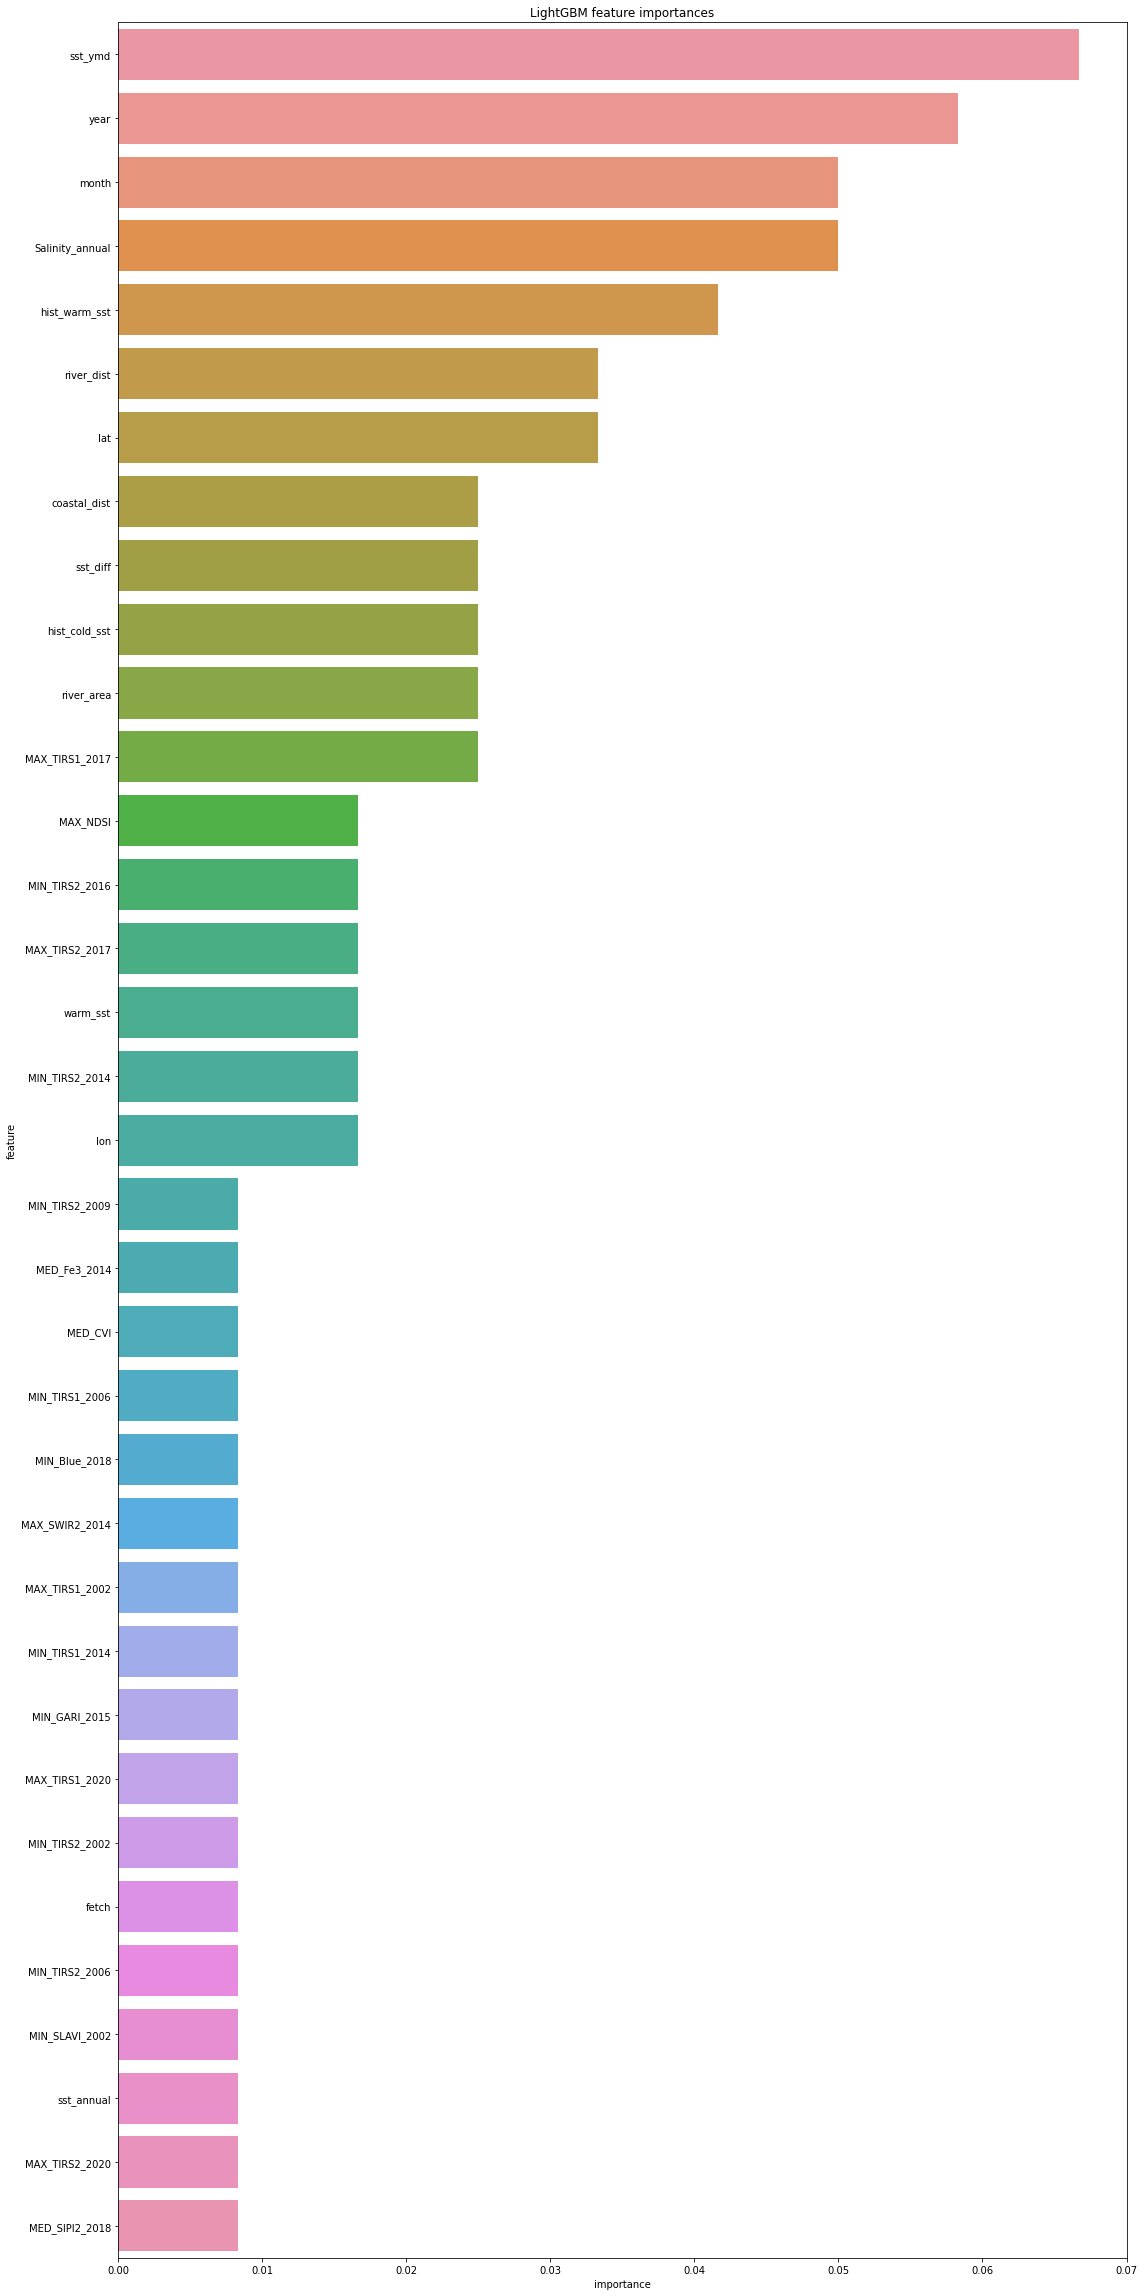

In [26]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)
oof_train = flag_oof.loc[flag_oof.adv_flag==0]
oof_train.sort_values("flag_pred", ascending=False, inplace=True)
oof_train = oof_train[:len(test)].reset_index(drop=True)

fold
0    1008
1    1008
2    1008
3    1015
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.854829


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.8548293311951596
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.825096


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.8250961870327224
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.744702


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.7447023585557018
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.597989


<ipython-input-25-4e8d325e2ecd>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.5979891493473352


,feature,importance
13,year,0.018750
2828,depth,0.010119
2242,warm_sst,0.009821
366,MIN_GARI,0.008631
1879,MIN_DVIMSS_2017,0.007738
205,MAX_TIRS1_2013,0.006845
327,Date_Acquired,0.006845
1462,MIN_RDVI_2020,0.004464
363,MIN_NLI_2017,0.004464
2959,MIN_GLI_2020,0.003571


RMSE 0.7619286883583438


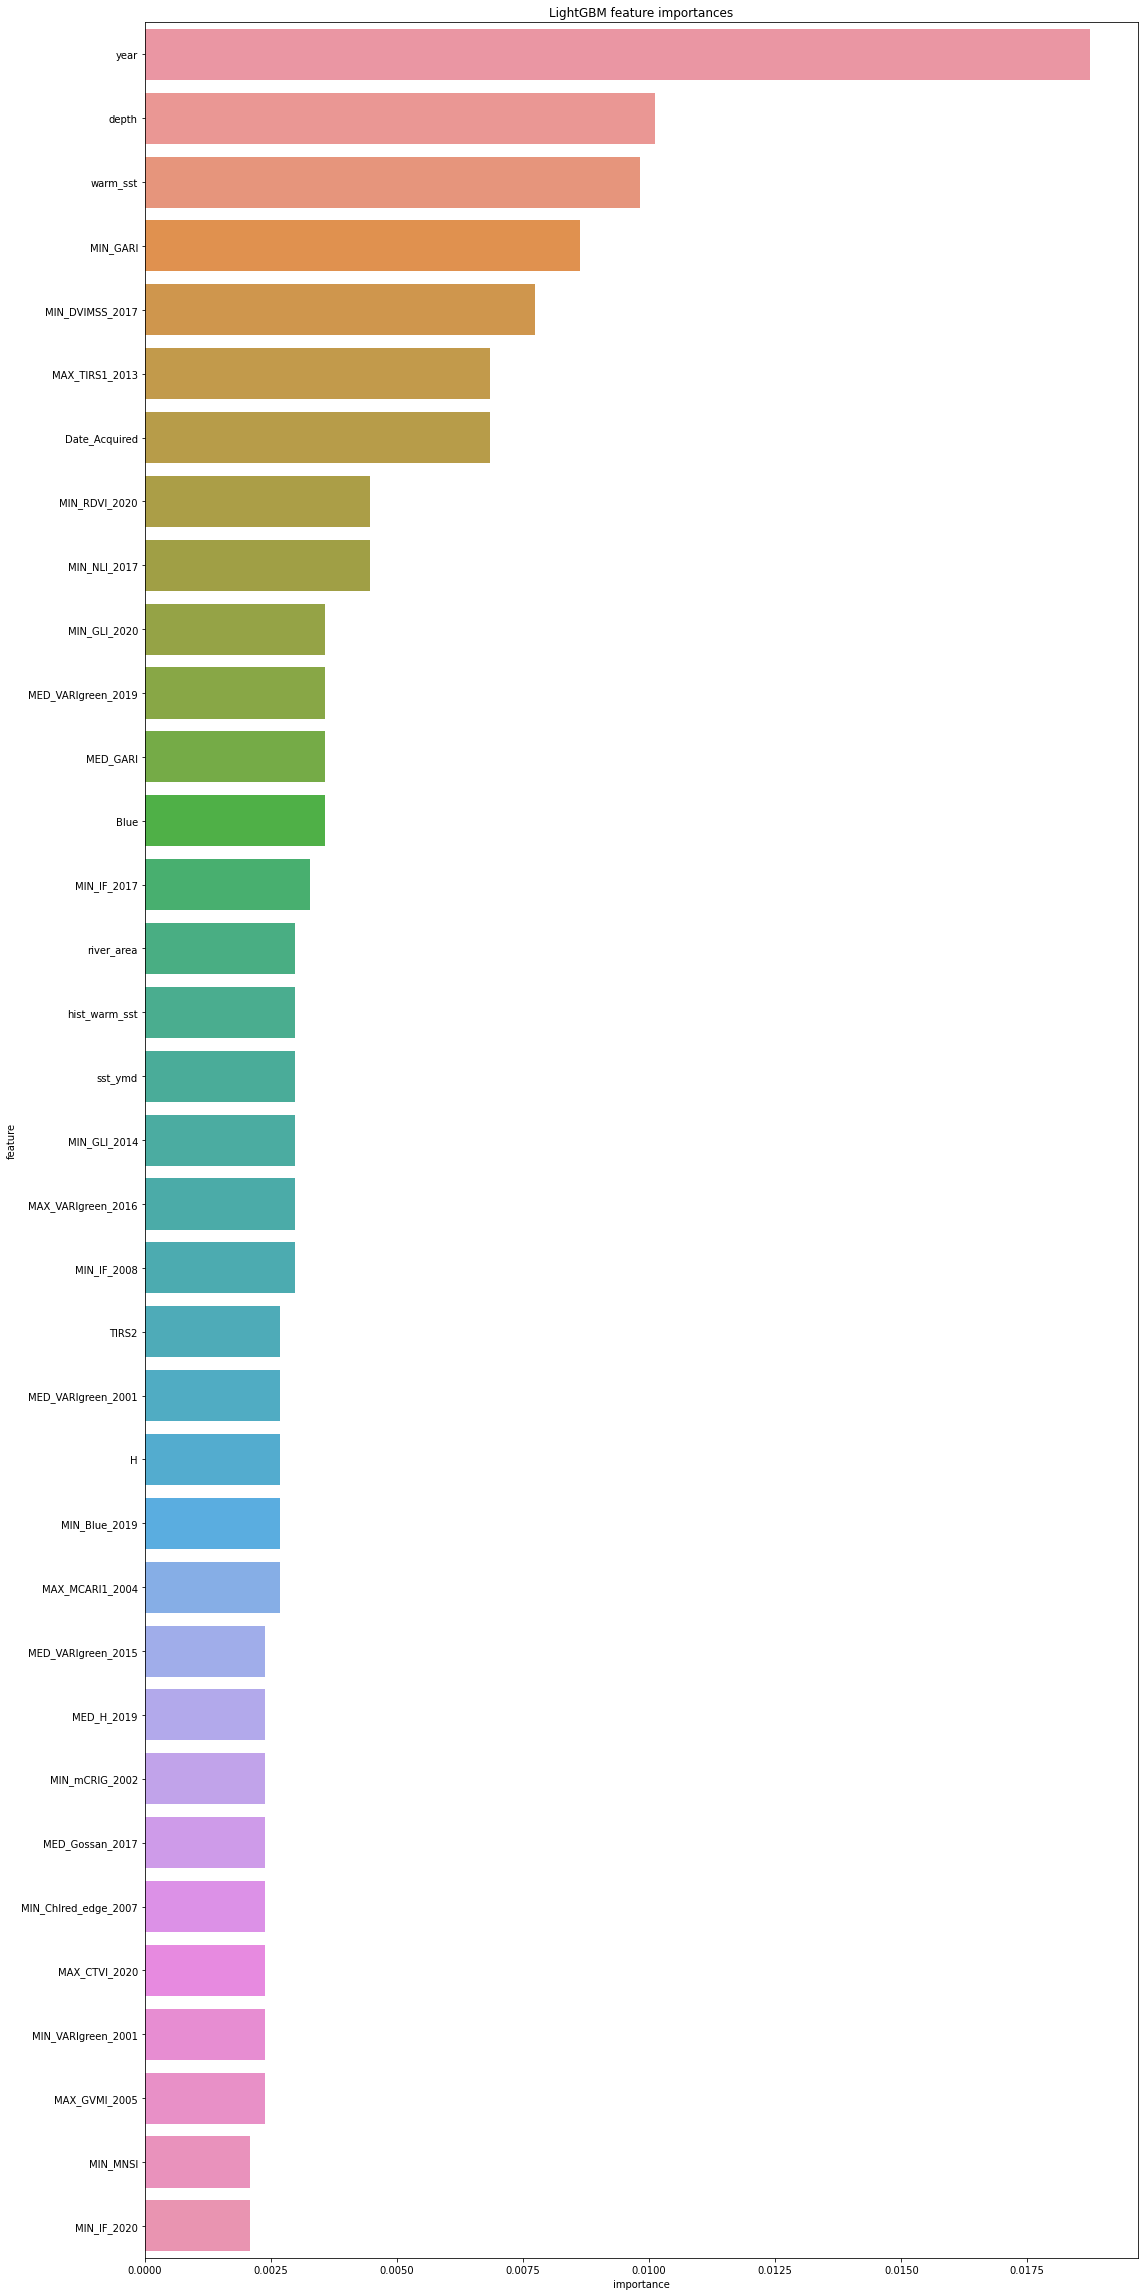

In [27]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(oof_train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [28]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.expm1(_oof["_pred"]) / _oof["area"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.2420706230339386


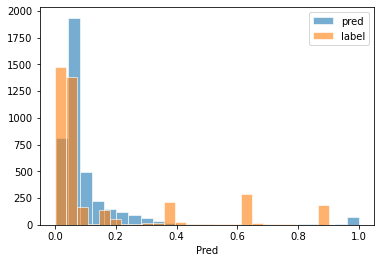

In [29]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [30]:
pred_df = test.copy()
pred_df["pred_area_log"] = np.mean(test_pred, axis=1)

pred_df["pred"] = np.expm1(pred_df["pred_area_log"]) / pred_df['area']
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.651017,0.045875
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.800641,0.061348
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.715286,0.010448
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.789061,0.060066
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.367321,0.146241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.908348,0.074011
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.760564,0.056974
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,0.816572,0.012627
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,0.801286,0.061420


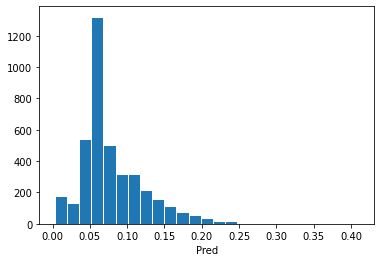

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.651017,0.045875
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.800641,0.061348
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.715286,0.010448
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,0.789061,0.060066
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.367321,0.146241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.908348,0.074011
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.760564,0.056974
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,0.816572,0.012627
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,0.801286,0.061420


In [31]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)